# Running quantum circuits on QPU devices

In this tutorial we show how to run circuits on QPU devices. We can run our circuit on both the superconducting machine from Rigetti and the ion-trap machine provided by IonQ. As shown below, one can seamlessly swap between different devices without any modifications to the circuit definition, by just re-defining the device object. We also show how to recover results using the unique ARN associated with every task. This tool is useful in order to deal with potential delays if your quantum task sits in the queue for some time waiting for execution. 

<h1 style="color:#D30982;">qBraid instructions</h1> 

If you are not planning to submit jobs to quantum computers, this notebook should work well with `Python [Default]` kernel. If you want to submit jobs to quantum computers, make sure that you have installed the amazon braket environment on qBraid ([installation instructions](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/lab/environments.html#install-environment)) and have selected the `Python [Braket]` kernel (Menu Bar->Kernel->Change Kernel).

If you do not have aws credentials for submitting your quantum jobs, you will need qBraid-Credits. If you have qBraid-Credits, you can run the following line of code to submit quantum jobs through qBraid

In [5]:
#!qbraid jobs enable amazon_braket #You only need to run this line once after you install the environment

In [6]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask
s3_folder = ("dummy_variable", "dummy_variable")

In [7]:
# print all (the usual suspects) available gates currently available within SDK
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print('Gate set supported by SDK:\n', gate_set)
print('\n') 

# the Rigetti device
device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the Rigetti device:\n', supported_gates)
print('\n') 

# the IonQ device
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the IonQ device:\n', supported_gates)
print('\n') 

# the Oxford Quantum Circuits (OQC) device
device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the OQC device:\n', supported_gates)

Gate set supported by SDK:
 ['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CV', 'CY', 'CZ', 'ECR', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


Gate set supported by the Rigetti device:
 ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z', 'start_verbatim_box', 'end_verbatim_box']


Gate set supported by the IonQ device:
 ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap', 'i']


Gate set supported by the OQC device:
 ['ccnot', 'cnot', 'cphaseshift', 'cswap', 'cy', 'cz', 'h', 'i', 'phaseshift', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'v', 'vi', 'x', 'y', 'z', 'ecr', 'start_verbatim_box', 'end_verbatim_box']


<h1 style="color:#D30982;">Investigate Entanglement</h1> 

### Create an entangled state

Goal: Prepare maximally entangled Bell state: 
$$\left|0,0\right> \rightarrow \left|\mathrm{Bell}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0\right> + \left|1,1\right>\right).$$

To this end, we build and run the following circuit using a single-qubit Hadamard gate (denoted as ```H```) acting on the first qubit followed by a two-qubit ```CNOT``` gate: 
<div>
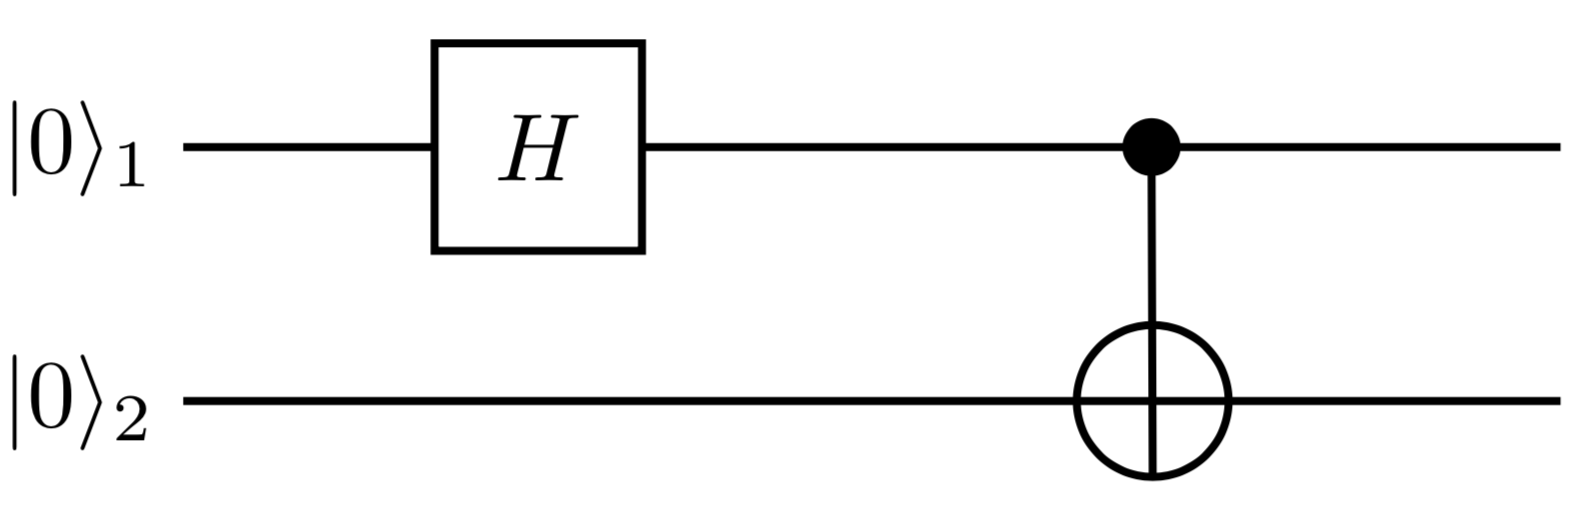
</div>

### Setup Circuit

In [8]:
# define circuit
bell = Circuit().h(0).cnot(0, 1)

In [9]:
# print circuit
print(bell, type(bell))


T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1| <class 'braket.circuits.circuit.Circuit'>


### Local Simulator

First we run our circuit locally, using an exact state-vector simulator. This local simulator is the preferred choice for fast experiments with low to intermediate qubit numbers ($N<20-25$) and essentially unlimited circuit depth. 

In [10]:
# set up device: Local Simulator
device = LocalSimulator()

In [11]:
# run circuit (execute single TASK)
result = device.run(bell, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'11': 505, '00': 495})


Text(0, 0.5, 'counts')

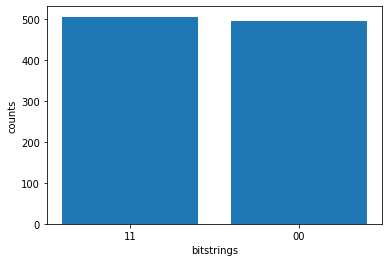

In [12]:
# plot using result
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

### Quantum Hardware: Rigetti

Next we submit our circuit to the superconducting quantum chip provided by Rigetti. Depending on our position in the queue, we may have to wait for some time till our circuit is actually run. However, thanks to asynchronous execution, we can always come back and recover the results by providing the unique ID associated with every task. 

In [16]:
# set up device
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2")

# create a clean circuit with no result type attached.(This is because some result types are only supported when shots=0)
bell = Circuit().h(0).cnot(0, 1)  

# add the Z \otimes Z expectation value
bell.expectation(Observable.Z() @ Observable.Z(), target=[0,1])

# run circuit 
rigetti_task = rigetti.run(bell, s3_folder,shots=1000)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()
# print('ID of task:', rigetti_task_id)
print('Status of task:', rigetti_status)

Status of task: QUEUED


The task is submitted and we can regularly (or irregularly) check the status of this task by executing the following cell. You may easily build logic around this query to wait for this task to complete before your code proceeds. 

In [15]:
# print status
status = rigetti_task.state()
print('Status of (reconstructed) task:', status)

Status of (reconstructed) task: COMPLETED


### Quantum Hardware: IonQ

Next, we submit our example Bell state circuit to IonQ. We set the device as AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice"). This task may not readily be executed but enter a queue for this specific machine. While we can interrupt our kernel (and work on something else), we can always recover our results using the unique ID of this task.

In [14]:
# set up device
ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

# run circuit
ionq_task = ionq.run(bell, s3_folder, shots=1000)

# get id and status of submitted task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
# print('ID of task:', ionq_task_id)
print('Status of task:', ionq_status)

Status of task: QUEUED


In [15]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) task:', status)

Status of (reconstructed) task: QUEUED


### Quantum Hardware: Oxford Quantum Circuits

Finally, we submit our circuit to the superconducting quantum computer provided by Oxford Quantum Circuits (OQC). The task runs asynchronously. We can retrieve the result when the task is completed.

In [17]:
# set up device
oqc = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")

# run circuit
oqc_task = oqc.run(bell,s3_folder, shots=1000)

# get id and status of submitted task
oqc_task_id = oqc_task.id
oqc_status = oqc_task.state()
# print('ID of task:', oqc_task_id)
print('Status of task:', oqc_status)

Status of task: QUEUED


### Task Recovery

By simply grabbing the unique task ID associated with the quantum tasks we have submitted above, we can recover this task at any point in time and (once the status is completed) visualize and analyze the corresponding results. Note that apart from other metadata, you can retrieve the compiled circuit that was actually run on the Rigetti device. More information about the compiling process can be found [here](https://pyquil-docs.rigetti.com/en/v2.22.0/compiler.html#partial). 

Status of (reconstructed) task: COMPLETED


1000 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.

Measurement counts: Counter({'00': 517, '11': 472, '01': 7, '10': 4})


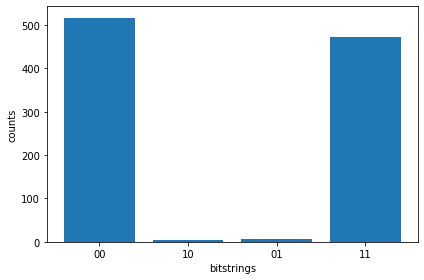

In [19]:
# recover task
task_load = AwsQuantumTask(arn="arn:aws:braket:us-east-1:592242689881:quantum-task/a197f55f-5d91-4e57-8ee7-7a839e1e021e")

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)
print('\n')
# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task_load.result()
    # print(results)
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.\n".format(shots, machine))
    
    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig('AWS_QC_results.png', dpi=700)
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

We have successfully recovered the results associated with the tasks that were queued up for the quantum hardware providers. Because of noise (decoherence) and other imperfections we cannot fully recover the exact results we have seen when using the classical simulator. To deal with that, in the fullness of time we will be able to use error correction techniques. As long as error correction is not available, it is important to benchmark our quantum results using classical simulators, whenever possible. 